# Fine-tune Enformer to perform binary classification on human snATAC-seq data

In this tutorial, we learn how to fine-tune the Enformer model (https://www.nature.com/articles/s41592-021-01252-x) on the CATLAS single-nucleus ATAC-seq dataset from human tissues (http://catlas.org/humanenhancer/). We will perform binary classification, in which the model learns to predict the probability that a given sequence is accessible in the different cell types of the dataset. For an example of regression modeling, see the next tutorial.

In [1]:
import anndata
import os
import importlib
import pandas as pd
import numpy as np

%matplotlib inline

## Set experiment parameters

In [2]:
experiment='tutorial_2'
if not os.path.exists(experiment):
    os.makedirs(experiment)

## Load data

We download the CATlas ATAC-seq binary cell type x peak matrix from http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/ and load it as an AnnData object.

In [3]:
!wget http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/matrix.tsv.gz
ad = anndata.read_mtx('matrix.tsv.gz').T

# Prepare ad.obs
ad.obs = pd.read_table('http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/celltypes.txt.gz', header=None, names=['cell type'])
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_table('http://catlas.org/catlas_downloads/humantissues/cCRE_hg38.tsv.gz')
var['width'] = var['hg38_End'] - var['hg38_Start']
var.columns = ['chrom', 'start', 'end', 'cre_class', 'in_fetal', 'in_adult', 'cre_module', 'width']
ad.var = var

print(ad.shape)

--2024-04-25 20:23:46--  http://catlas.org/catlas_downloads/humantissues/cCRE_by_cell_type/matrix.tsv.gz
Resolving catlas.org (catlas.org)... 132.239.162.129
Connecting to catlas.org (catlas.org)|132.239.162.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38772708 (37M) [application/x-gzip]
Saving to: ‘matrix.tsv.gz’

matrix.tsv.gz       100%[===================>]  36.98M  78.0MB/s    in 0.5s    

2024-04-25 20:23:47 (78.0 MB/s) - ‘matrix.tsv.gz’ saved [38772708/38772708]

(222, 1154611)


This contains 1154611 CREs measured in 222 cell types. Let us look at the components of this object:

In [4]:
ad.var.head()

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module,width
0,chr1,9955,10355,Promoter Proximal,yes,yes,146,400
1,chr1,29163,29563,Promoter,yes,yes,37,400
2,chr1,79215,79615,Distal,no,yes,75,400
3,chr1,102755,103155,Distal,no,yes,51,400
4,chr1,115530,115930,Distal,yes,no,36,400


In [5]:
ad.obs.head()

,cell type
cell type,
Follicular,Follicular
Fibro General,Fibro General
Acinar,Acinar
T Lymphocyte 1 (CD8+),T Lymphocyte 1 (CD8+)
T lymphocyte 2 (CD4+),T lymphocyte 2 (CD4+)


The contents of this anndata object are binary values (0 or 1). 1 indicates accessibility of the peak in the cell type.

In [6]:
ad.X[:5, :5].todense()

matrix([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32)

## Filter peaks

We will perform quality filtering of the dataset using the `grelu.data.preprocess` module.

In [7]:
import grelu.data.preprocess

# Filter peaks within autosomes
ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 1121319 intervals


In [8]:
# Drop peaks overlapping with the blacklist regions
ad = grelu.data.preprocess.filter_blacklist(ad, genome='hg38')

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Keeping 1117353 intervals


## Visualize data

In [9]:
import grelu.visualize
%matplotlib inline

How many accessible cell types does each peak have?

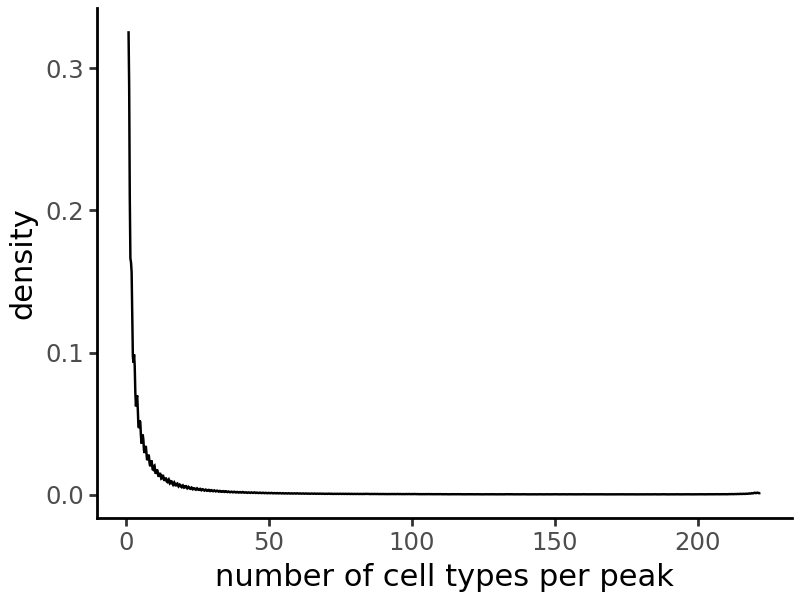

In [10]:
cell_types_per_peak = np.array(np.sum(ad.X > 0, axis=0))

grelu.visualize.plot_distribution(
    cell_types_per_peak,
    title='number of cell types per peak',
    method='density'
)

How many peaks are accessible in each cell type?

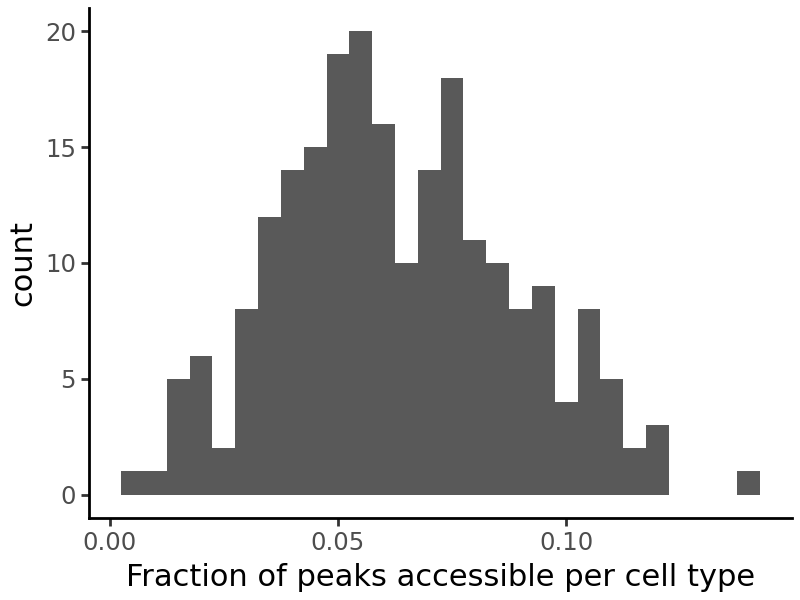

In [11]:
fraction_accessible_per_cell_type = np.array(np.mean(ad.X > 0, axis=1))

grelu.visualize.plot_distribution(
    fraction_accessible_per_cell_type,
    title='Fraction of peaks accessible per cell type',
    method='histogram',
    binwidth=0.005,
)

It seems that some cell types have very few accessible peaks. We will drop these:

In [12]:
# Filter cell types with very few peaks
print(ad.shape)
ad = ad[ad.X.mean(axis=1) > .03, :]
print(ad.shape)

(222, 1117353)
(203, 1117353)


Leaving 203 cell types.

## Resize peaks

Finally, since the ATAC-seq peaks can have different lengths, we resize all of them to a constant length in order to train the model. Here, we take 200 bp. We can use the `resize` function in `grelu.sequence.utils`, which contains functions to manipulate DNA sequences.

In [13]:
import grelu.sequence.utils
seq_len = 200

ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module,width
27,chr1,794997,795197,Distal,yes,yes,27,400
28,chr1,804833,805033,Promoter Proximal,no,yes,90,400
29,chr1,816263,816463,Promoter Proximal,yes,no,21,400


## Split data

We will split the peaks by chromosome to create separate sets for training, validation and testing.

In [14]:
train_chroms='autosomes'
val_chroms=['chr10']
test_chroms=['chr11']

ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad,
    train_chroms=train_chroms, val_chroms=val_chroms, test_chroms=test_chroms,
)

Selecting training samples
Keeping 1004076 intervals


Selecting validation samples
Keeping 56911 intervals


Selecting test samples
Keeping 56366 intervals
Final sizes: train: (203, 1004076), val: (203, 56911), test: (203, 56366)


## Make labeled sequence datasets

`grelu.data.dataset` contains PyTorch Dataset classes that can load and process genomic data for training a deep learning model. Here, we use the `AnnDataSeqDataset` class which loads data from an AnnData object. Other availabel dataset classes include `DFSeqDataset` and `BigWigSeqDataset`.

In [15]:
import grelu.data.dataset

In [16]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_train, genome='hg38')
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val, genome='hg38')
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test, genome='hg38')

For the validation and test datasets, we will not use any augmentation.

## Build the enformer model

gReLU contains many model architectures. One of these is a special class called `EnformerPretrainedModel`. This class creates a model identical to the published Enformer model and initialized with the trained weights, but where you can change the number of transformer layers and the output head.

Models are created using the `grelu.lightning` module. In order to instantiate a model, we need to specify `model_params` (parameters for the model architecture) and `train_params` (parameters for training).

In [17]:
model_params = {
    'model_type':'EnformerPretrainedModel', # Type of model
    'n_tasks': 203, # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 1, # Number of transformer layers; the published Enformer model has 11
}

train_params = {
    'task':'binary', # binary classification
    'lr':1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size': 1024,
    'num_workers': 8,
    'devices': 0, # GPU index
    'save_dir': experiment,
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params=model_params, train_params=train_params)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lal-avantika (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5


## Train the model

We train the model on the new training dataset using the `train_on_dataset` method. Note that here, we update the weights of the entire model during training. If you want to hold the enformer weights fixed and only learn a linear layer from the enformer embedding to the outputs, see the `tune_on_dataset` method.

In [18]:
# See the 'tutorial_2' folder for logs
trainer = model.train_on_dataset(train_dataset=train_dataset, val_dataset=val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tutorial_2/2024_19_04_19_27
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:08<00:00,  6.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5283154249191284     │
│         val_auroc         │    0.5033195614814758     │
│        val_avgprec        │    0.10945382714271545    │
│        val_best_f1        │    0.1733759045600891     │
│         val_loss          │    0.6917599439620972     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params
---------------------------------------------------------
0 | model        | EnformerPretrainedModel | 72.1 M
1 | loss         | BCEWithLogitsLoss       | 0     
2 | val_metrics  | MetricCollection        | 0     
3 | test_metrics | MetricCollection        | 0     
4 | transform    | Identity                | 0     
---------------------------------------------------------
72.1 M    Trainable params
0         Non-trainable params
72.1 M    Total params
288.267   Total estimated model params size (MB)


Epoch 0: 100%|██████████████████████████████████████████████████████████████████| 981/981 [03:27<00:00,  4.73it/s, v_num=0, train_loss_step=0.141]
Validation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████| 981/981 [04:37<00:00,  3.54it/s, v_num=0, train_loss_step=0.139, train_loss_epoch=0.170]
Validation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████| 981/981 [03:29<00:00,  4.68it/s, v_num=0, train_loss_step=0.142, train_loss_epoch=0.150]
Validation: |                                                                                                               | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████████████████████████████████████| 981/981 [03:28<00:00,  4.70it/s, v_num=0, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████████████████████████████████████| 981/981 [04:01<00:00,  4.07it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.129]


## Load best model from checkpoint

During training, the performance of the model on the validation set is checked after each epoch. We will load the version of the model that had the best validation set performance.

In [39]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.4


## Calculate performance metrics on the test set

We calculate global performance metrics using the `test_on_dataset` method.

In [19]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=1024,
)
test_metrics.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:05<00:00,  9.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9429274797439575     │
│        test_auroc         │    0.8972363471984863     │
│       test_avgprec        │    0.5834904909133911     │
│       test_best_f1        │    0.5513458251953125     │
│         test_loss         │    0.1626424789428711     │
└───────────────────────────┴───────────────────────────┘

,test_accuracy,test_auroc,test_avgprec,test_best_f1
Follicular,0.905528,0.873146,0.873146,0.565334
Fibro General,0.911649,0.874038,0.874038,0.558457
Acinar,0.940106,0.906093,0.906093,0.582743
T Lymphocyte 1 (CD8+),0.958255,0.924713,0.924713,0.576182
T lymphocyte 2 (CD4+),0.964464,0.933238,0.933238,0.559400


## Visualize performance metrics

We can plot the distribution of each metric across all 203 tasks:

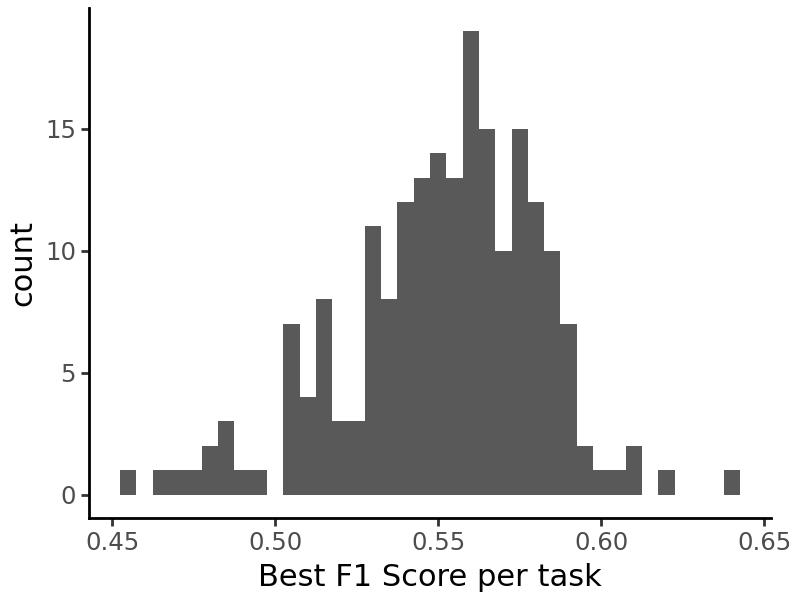

In [20]:
grelu.visualize.plot_distribution(
    test_metrics.test_best_f1,
    method='histogram',
    title='Best F1 Score per task',
    binwidth=0.005
)

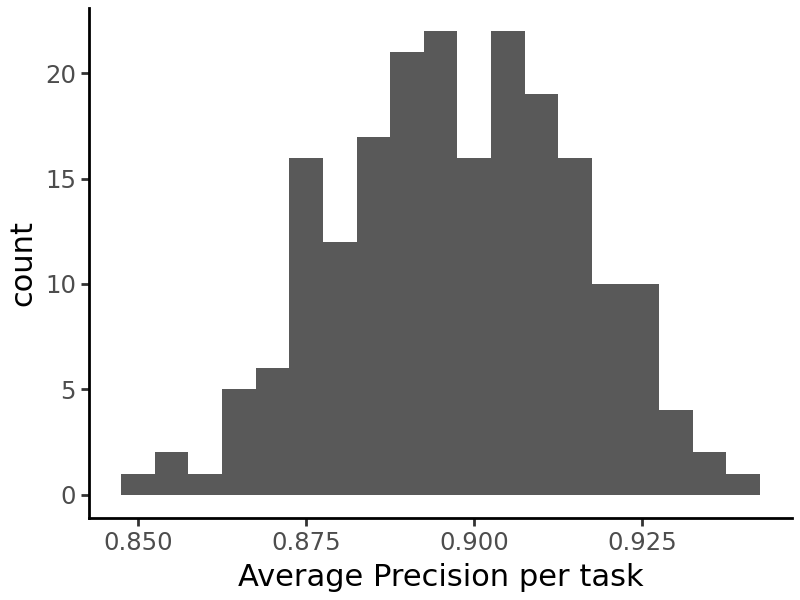

In [21]:
grelu.visualize.plot_distribution(
    test_metrics.test_avgprec,
    method='histogram',
    title='Average Precision per task',
    binwidth=0.005,
)

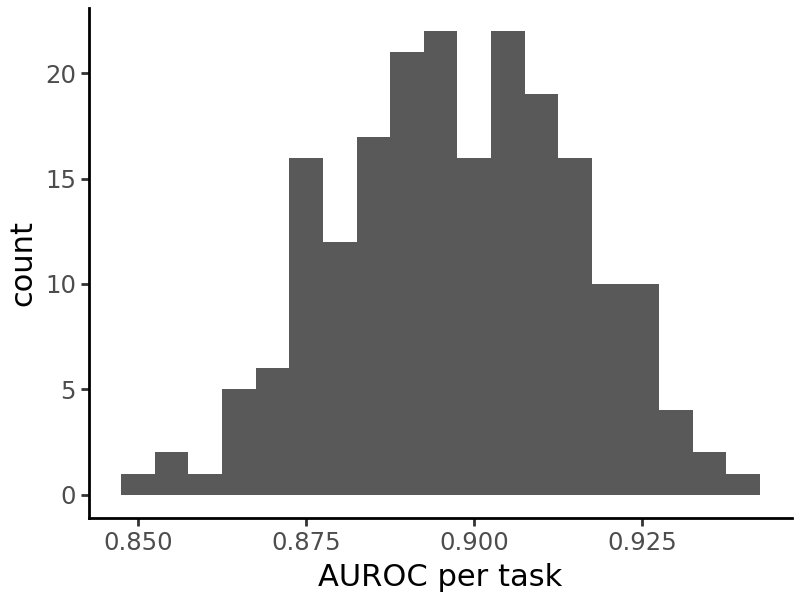

In [22]:
grelu.visualize.plot_distribution(
    test_metrics.test_auroc,
    method='histogram',
    title='AUROC per task',
    binwidth=0.005,
)

## Run inference on the test set

Instead of overall metrics, we can also get the individual predictions for each test set example.

In [23]:
probs = model.predict_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=1024,
    return_df=True # Return the output as a pandas dataframe
)

probs.head()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 14.19it/s]


,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+),Natural Killer T,Naive T,Fibro Epithelial,Cardiac Pericyte 1,Pericyte General 1,...,Fetal Cardiac Fibroblast,Fetal Fibro General 2,Fetal Fibro Muscle 1,Fetal Fibro General 3,Fetal Mesangial 2,Fetal Stellate,Fetal Alveolar Epithelial 1,Fetal Cilliated,Fetal Excitatory Neuron 1,Fetal Excitatory Neuron 2
0,0.039343,0.085656,0.023085,0.069776,0.031169,0.049884,0.031118,0.084030,0.028341,0.038819,...,0.147001,0.111375,0.112192,0.132647,0.150558,0.061355,0.188503,0.168673,0.178571,0.043005
1,0.054403,0.041913,0.030041,0.023362,0.012743,0.008804,0.007916,0.021082,0.029804,0.030945,...,0.087696,0.067736,0.040762,0.080000,0.089734,0.018170,0.180756,0.152147,0.077397,0.011705
2,0.033326,0.075534,0.026377,0.026982,0.013187,0.015589,0.013410,0.052365,0.048863,0.055269,...,0.153047,0.097405,0.090740,0.111889,0.150595,0.035322,0.191916,0.117977,0.128392,0.023208
3,0.099414,0.032237,0.021758,0.020585,0.011158,0.012512,0.006998,0.029126,0.022186,0.019099,...,0.028560,0.019027,0.015915,0.026139,0.025520,0.011255,0.076503,0.061990,0.032474,0.010206
4,0.009510,0.011181,0.004723,0.154428,0.118982,0.175104,0.093552,0.006301,0.008546,0.002844,...,0.007390,0.003049,0.003549,0.007652,0.005219,0.001400,0.027313,0.014515,0.011029,0.004248


Since this is a binary classification model, the output takes the form of probabilities ranging from 0 to 1. We interpret these as the predicted probabilities of the element being accessible in each cell type.

## Plot additional visualizations of the predictions

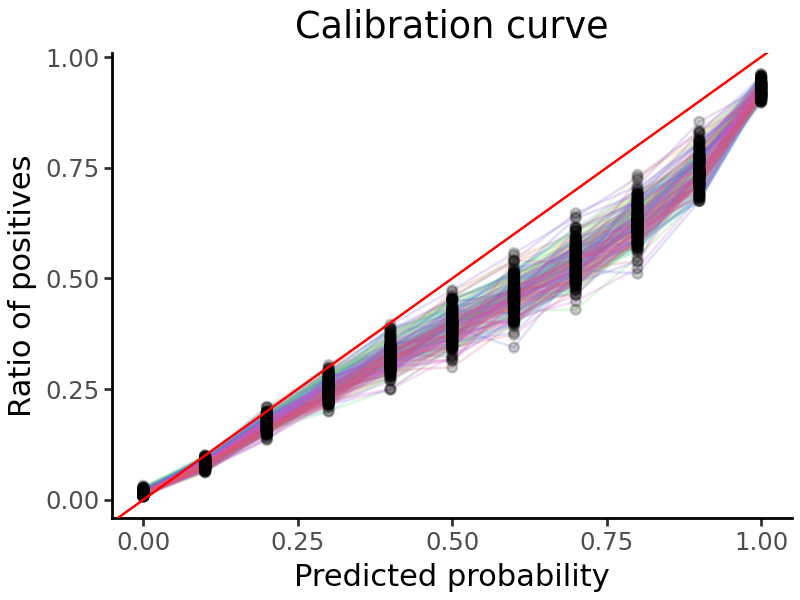

In [24]:
# Plot a calibration curve for all tasks

grelu.visualize.plot_calibration_curve(
    probs, labels=test_dataset.labels, aggregate=False, show_legend=False
)

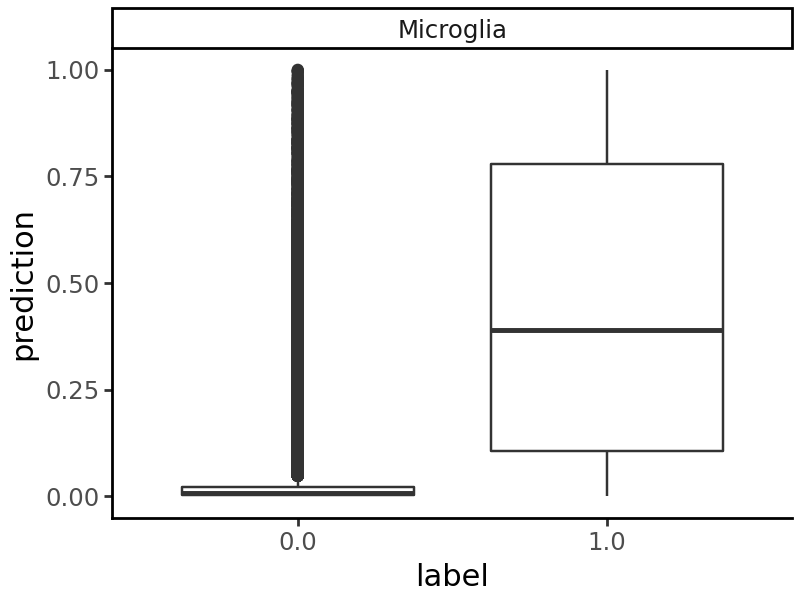

In [25]:
# Compare the predictions on accessible and non-accessible elements in a 
# single cell type
grelu.visualize.plot_binary_preds(
    probs, labels=test_dataset.labels, tasks='Microglia'
)

## Interpret model predictions (for microglia) using TF-modisco

Suppose we want to focus specifically on Microglia. We can create a transform - a class that takes in the model's prediction and returns a function of the prediction, e.g. the prediction for only a subset of cell types that we are interested in. Then, all subsquent analyses that we do will be based only on this subset.

In [28]:
from grelu.transforms.prediction_transforms import Aggregate

microglia_score = Aggregate(
    tasks = ["Microglia"],
    model = model,
)

Let us now identify all peaks in the test set that are accessible in microglia.

In [27]:
is_accessible_in_mcg = (ad_test["Microglia", :].X.A==1).squeeze()
mcg_peaks = ad_test.var[is_accessible_in_mcg]
len(mcg_peaks)

2271

We now run TF-Modisco on these peaks. TF-modisco identifies motifs that consistently contribute to the model's output. Since we are using the microglia filter to limit the model's prediction to microglia, we will only get motifs relevant to this cell type. We also use TOMTOM to match the Modisco motifs to a set of reference motifs. Here, we use a reference set of non-redundant motifs (https://www.vierstra.org/resources/motif_clustering) that are provided with gReLU as `consensus`.

In [44]:
%%time
import grelu.interpret.score
importlib.reload(grelu.interpret.score)

grelu.interpret.score.run_modisco(
    model,
    seqs=mcg_peaks, 
    genome="hg38",
    prediction_transform=microglia_score, # Base importance scores will be calculated with respect to this output
    meme_file="consensus", # We will compare the Modisco CWMs to consensus motifs
    method="ism",
    out_dir=experiment,
    batch_size=1024,
    devices=1,
    window=100,
    seed=0,
)

/usr/local/lib/python3.11/dist-packages/grelu/sequence/utils.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Performing ISM


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.84it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████| 666/666 [00:45<00:00, 14.65it/s]
Running modisco
Writing modisco output
Making report
CPU times: user 40min 24s, sys: 53 s, total: 41min 17s
Wall time: 1min 25s


## Load TOMTOM output for modisco motifs

The full output of TF-Modisco can be found in the experiment folder. Here, we list the significant TOMTOM matches, i.e. known TF motifs that are similar to those found by TF-MoDISco.

In [45]:
import grelu.io
tomtom_dir = os.path.join(experiment, 'tomtom')

tomtom = grelu.io.read_tomtom(tomtom_dir, qthresh=.01) # Read only significant matches
tomtom

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,pos_patterns.pattern_0,AC0078:CTCF_CTCFL:C2H2_ZF,-1.0,2.372120e-14,1.511040e-11,3.022080e-11,13.0,CCGCCCCCTAGTGG,CGCCCCCTGGTGG,+
35,pos_patterns.pattern_1,AC0227:SPI_BCL11A:Ets,2.0,2.506640e-06,1.596730e-03,3.193460e-03,10.0,ACTTCCTCTTT,TCACTTCCTCTT,-
36,pos_patterns.pattern_1,AC0622:ELF_SPIB:Ets,0.0,8.354910e-06,5.322080e-03,5.322080e-03,10.0,ACTTCCTCTTT,ACTTCCTCTT,-
